In [577]:
from __future__ import print_function
from __future__ import division

import os
import cv2
import numpy as np
import gzip
import matplotlib.pyplot as plt
from scipy.misc import imsave

from scipy.ndimage.morphology import distance_transform_edt as edt

from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
#from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Dropout
from keras.layers import *
from keras.layers.merge import concatenate
from keras.models import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from keras import losses

import time
from keras.callbacks import TensorBoard


from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

# Test for commit 

## Constants

In [3]:
# PATH definition
global_path = "src/10_08_myelin"
initial_weights_path = "src/models/initial_weights.hdf5"
final_weights_path = "src/models/output_weights_batch_norm.hdf5"

# Data definition
# image dimension (array)
img_rows = 512
img_cols = 512


nb_total = 69 # total number of img
nb_train = 53 # number of train img
nb_labeled = 53 # number of labeled image
nb_unlabeled = nb_train - nb_labeled # number of unlabeled images

# CEAL parameters
apply_edt = False
nb_iterations = 1 # number of active iteration

nb_step_predictions = 10

# For sample selection to present to the oracle
nb_no_detections = 1 # number of samples in the histogram area with accuracy = 0 (no detection)
nb_random = 1 # number of randomly selected samples
nb_most_uncertain = 1 # number of samples selected in the most uncertain area (highest uncertainty)
most_uncertain_rate = 1 # threshold to define the most uncertain area. 

# this 2+2+2 samples are presented to oracle for annotation

pseudo_epoch = 5
nb_pseudo_initial = 1
pseudo_rate = 2

initial_train = True
nb_initial_epochs = 10
nb_active_epochs = 2
batch_size = 10
steps_per_epoch = nb_labeled / batch_size

apply_augmentation = True
featurewise_center = True
featurewise_std_normalization= True
rotation_range= 40
horizontal_flip= True
vertical_flip =True
zca_whitening = True
rescale = 1./255
zoom_range= 0.2
channel_shift_range = 0.2


learning_rate = 1e-3
decay_rate = learning_rate / nb_initial_epochs




In [16]:
def save_parameters(timestamp, params):
    param_file = str("params/" + timestamp + '.txt')
    
    txt_file = open(param_file,'w')
    txt_file.write(str(params))
    txt_file.close()
    
def get_params(img_rows, img_cols, nb_total, nb_train, nb_labeled, nb_unlabeled, apply_edt, nb_iterations, 
               nb_step_predictions, initial_train, nb_initial_epochs, nb_active_epochs, batch_size, 
              learning_rate, decay_rate, apply_augmentation,  featurewise_center, featurewise_std_normalization, 
              rotation_range, horizontal_flip, vertical_flip, zca_whitening, rescale, channel_shift_range, zoom_range ):
    
    param_dict = {
    'img_rows':img_rows,
    'img_cols' : img_cols,


    'nb_total' : nb_total,
    'nb_train' : nb_train,
    'nb_labeled' : nb_labeled,
    'nb_unlabeled' : nb_unlabeled,

    # CEAL parameters
    'apply_edt' : apply_edt,
    'nb_iterations' : nb_iterations,

    'nb_step_predictions' : nb_step_predictions,

    'initial_train' : initial_train,
    'nb_initial_epochs' : nb_initial_epochs,
    'nb_active_epochs' : nb_active_epochs,
    'batch_size' : batch_size,


    'learning_rate' : learning_rate,
    'decay_rate' : decay_rate,
    # Data augmentation
    'apply_augmentation' : apply_augmentation,
    'featurewise_center' : featurewise_center,
    'featurewise_std_normalization': featurewise_std_normalization,
    'rotation_range': rotation_range,
    'horizontal_flip': horizontal_flip,
    'vertical_flip' : vertical_flip,
    'zca_whitening' : zca_whitening, 
    'rescale' : rescale,
    'zoom_range': zoom_range,
    'channel_shift_range' : channel_shift_range
    }
    
    return param_dict

## Utils

In [17]:
def loss_measure(history):
    loss = history.history["loss"]
    dice_coef = history.history["dice_coef"]
    return loss, dice_coef

            
def preprocessor(input_img):
    """
    Resize input images to constants sizes
    :param input_img: numpy array of images
    :return: numpy array of preprocessed images
    """
    output_img = np.ndarray((input_img.shape[0], input_img.shape[1], img_rows, img_cols), dtype=np.uint8)
    for i in range(input_img.shape[0]):
        output_img[i, 0] = cv2.resize(input_img[i, 0], (img_cols, img_rows), interpolation=cv2.INTER_CUBIC)
    return output_img

def load_data(path_img, path_mask):
    """
    Load data from project path
    :return: [X, y] numpy arrays containing the [training, validation, test] data and their respective masks.
    """
    print("\nLoading data...\n")
    X = np.load(path_img)
    y = np.load(path_mask)

    X = preprocessor(X)
    y = preprocessor(y)

    X = X.astype('float32')

    mean = np.mean(X)  # mean for data centering
    std = np.std(X)  # std for data normalization

    X -= mean
    X /= std

    y = y.astype('float32')
    y /= 255.  # scale masks to [0, 1]
    return X, y

## U Net

In [18]:
K.set_image_dim_ordering('th')  # Theano dimension ordering in this code

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection ) / (K.sum(y_true_f) + K.sum(y_pred_f))


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


#Override Dropout. Make it able at test time.
def call(self, inputs, training=None):
    if 0. < self.rate < 1.:
        noise_shape = self._get_noise_shape(inputs)
        def dropped_inputs():
            return K.dropout(inputs, self.rate, noise_shape,
                             seed=self.seed)
        if (training):
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        else:
            return K.in_test_phase(dropped_inputs, inputs, training=None)
    return inputs


def data_generator():
    """
    :return: Keras data generator. Data augmentation parameters.
    """
    return ImageDataGenerator(
        featurewise_center = featurewise_center,
        featurewise_std_normalization = featurewise_std_normalization,
        rotation_range = rotation_range,
        horizontal_flip = horizontal_flip,
        vertical_flip = vertical_flip,
        zca_whitening = zca_whitening, 
        rescale = rescale,
        zoom_range = zoom_range,
        channel_shift_range = channel_shift_range)



def predict(data, model):
    """
    Data prediction for a given model
    :param data: input data to predict.
    :param model: unet model.
    :return: predictions.
    """
    return model.predict(data, verbose=0)

def compute_dice_coef(y_true, y_pred):
    """
    Computes the Dice-Coefficient of a prediction given its ground truth.
    :param y_true: Ground truth.
    :param y_pred: Prediction.
    :return: Dice-Coefficient value.
    """
    smooth = 1.  # smoothing value to deal zero denominators.
    y_true_f = y_true.reshape([1, img_rows * img_cols])
    y_pred_f = y_pred.reshape([1, img_rows * img_cols])
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def compute_uncertain(sample, prediction, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param prediction: input sample prediction.
    :param model: unet model with Dropout layers.
    :return: overall uncertainty (not map) .
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return np.sum(var * transform)

    else:
        return np.sum(np.var(X, axis=0))

def compute_uncertain_map(sample, prediction, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param prediction: input sample prediction.
    :param model: unet model with Dropout layers.
    :return: uncertainty map.
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return var * transform

    else:
        return np.var(X, axis=0)   

def range_transform(sample):
    """
    Range normalization for 255 range of values
    :param sample: numpy array for normalize
    :return: normalize numpy array
    """
    if (np.max(sample) == 1):
        sample = sample * 255

    m = 255 / (np.max(sample) - np.min(sample))
    n = 255 - m * np.max(sample)
    return (m * sample + n) / 255
    
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
    
Dropout.call = call

In [21]:
pwd

u'/Users/mulab_admin/Documents/CEAL/CEAL-Medical-Image-Segmentation'

In [24]:
path_img_train = 'src/data/data_rosenberg2/images_69.npy'
path_mask_train = 'src/data/data_rosenberg2/masks_69.npy'

path_img_valid = 'src/data/data_rosenberg2/images_valid_29.npy'
path_mask_valid = 'src/data/data_rosenberg2/masks_valid_29.npy'


path_img_test = 'src/data/data_rosenberg2/images_test_1.npy'
path_mask_test = 'src/data/data_rosenberg2/masks_test_1.npy'


log_file = open("log_file_jupyter_myelin.txt", 'a')

In [28]:
X_train, y_train = load_data(path_img_train, path_mask_train )
print("*************Xtrain.shape***********", y_train.shape)
labeled_index = np.arange(0, nb_labeled)
unlabeled_index = np.arange(nb_labeled, len(X_train))
print(len(labeled_index))

# CEAL data definition
X_valid, y_valid = load_data(path_img_valid, path_mask_valid)
print("*************Xvalid.shape***********", X_valid.shape)

# CEAL data definition
X_test, y_test = load_data(path_img_test, path_mask_test)
print("*************Xtest.shape***********", X_test.shape)



Loading data...

*************Xtrain.shape*********** (69, 1, 512, 512)
53

Loading data...

*************Xvalid.shape*********** (29, 1, 512, 512)

Loading data...

*************Xtest.shape*********** (1, 1, 512, 512)


In [26]:
X_valid = X_valid[:-2]
y_valid = y_valid[:-2]

X_test = X_valid[-2:]
y_test = y_valid[-2:]


print(X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

(27, 1, 512, 512) (27, 1, 512, 512) (2, 1, 512, 512) (2, 1, 512, 512)


In [27]:
# PATH definition
global_path = "src/10_08_myelin"
initial_weights_path = "src/models/initial_weights.hdf5"
final_weights_path = "src/models/output_weights_batch_norm.hdf5"

# Data definition
# image dimension (array)
img_rows = 512
img_cols = 512


nb_total = 69 # total number of img
nb_train = 53 # number of train img
nb_labeled = 53 # number of labeled image
nb_unlabeled = nb_train - nb_labeled # number of unlabeled images

# CEAL parameters
apply_edt = False
nb_iterations = 1 # number of active iteration

nb_step_predictions = 10

# For sample selection to present to the oracle
nb_no_detections = 1 # number of samples in the histogram area with accuracy = 0 (no detection)
nb_random = 1 # number of randomly selected samples
nb_most_uncertain = 1 # number of samples selected in the most uncertain area (highest uncertainty)
most_uncertain_rate = 1 # threshold to define the most uncertain area. 

# this 2+2+2 samples are presented to oracle for annotation

pseudo_epoch = 5
nb_pseudo_initial = 1
pseudo_rate = 2

initial_train = True
nb_initial_epochs = 10
nb_active_epochs = 2
batch_size = 10
steps_per_epoch = nb_labeled / batch_size

apply_augmentation = True
featurewise_center = True
featurewise_std_normalization= True
rotation_range= 40
horizontal_flip= True
vertical_flip =True
zca_whitening = True
rescale = 1./255
zoom_range= 0.2
channel_shift_range = 0.2


learning_rate = 1e-3
decay_rate = learning_rate / nb_initial_epochs




In [31]:
# (1) Initialize model
model = unet_full_bn(dropout=True)
reset_weights(model)

print(model.summary())

params = get_params(img_rows, img_cols, nb_total, nb_train, nb_labeled, nb_unlabeled, apply_edt, nb_iterations, 
               nb_step_predictions, initial_train, nb_initial_epochs, nb_active_epochs, batch_size, 
              learning_rate, decay_rate, apply_augmentation,  featurewise_center, featurewise_std_normalization, 
              rotation_range, horizontal_flip, vertical_flip, zca_whitening, rescale, channel_shift_range, zoom_range )

# data augmentation
train_generator = data_generator().flow(X_train[labeled_index], y_train[labeled_index],
                                      batch_size=batch_size, 
                                      shuffle=True)

val_generator = data_generator().flow(X_valid, y_valid,
                                      batch_size=batch_size, 
                                      shuffle=True)

# training
if initial_train:
    model_checkpoint = ModelCheckpoint(initial_weights_path, monitor='loss', save_best_only=True)

    if apply_augmentation:
        timestamp = format(time.strftime('%m%d_%H%M_%S'))
        tensorboard = TensorBoard(log_dir = str("logs/" + str(timestamp)))
        save_parameters(timestamp, params)
        
        history = model.fit_generator(train_generator, 
                                      validation_data=val_generator,
                                    epochs=nb_initial_epochs, verbose=1, callbacks=[tensorboard])
        
        model.save(initial_weights_path)
   
    else:
        timestamp = format(time.strftime('%m%d_%H%M_%S'))
        tensorboard = TensorBoard(log_dir = str("logs/" + str(timestamp)))
        #save_parameters(timestamp, params)
        
        history = model.fit(X_train[labeled_index], y_train[labeled_index], validation_data=(X_valid, y_valid),
                            batch_size=batch_size, 
                            epochs=nb_initial_epochs,
                            verbose=1, shuffle=True, callbacks=[tensorboard])

else:
    model.load_weights(initial_weights_path)
    
print("Saving model...\n")   
model.save(final_weights_path)



# uncertainty computation

weights = final_weights_path
modelUncertain = unet_full_bn(dropout=True)
modelUncertain.load_weights(weights)

uncertain = np.zeros(len(X_test))
accuracy = np.zeros(len(X_test))
uncertain_map = []

print("Computing log predictions ...\n")
predictions = predict(X_test, model)

for i in range(len(X_test)):
    sample = X_test[i].reshape([1, 1, img_rows, img_cols])
    sample_prediction = cv2.threshold(predictions[i], 0.5, 1, cv2.THRESH_BINARY)[1].astype('uint8')
    accuracy[i] = compute_dice_coef(y_train[i][0], sample_prediction)
    uncertain[i] = compute_uncertain(sample, sample_prediction, modelUncertain)
    uncertain_map_i = compute_uncertain_map(sample, sample_prediction, modelUncertain)
    uncertain_map.append(uncertain_map_i)
    
    
uncertain_map_array = np.asarray(uncertain_map)
print(uncertain_map_array.shape)
print("Done")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1, 512, 512)  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 32, 512, 512) 320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 32, 512, 512) 9248        conv2d_39[0][0]                  
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 32, 512, 512) 128         conv2d_40[0][0]                  
__________________________________________________________________________________________________
max_poolin

Epoch 1/10


/Users/mulab_admin/anaconda2/lib/python2.7/site-packages/keras_preprocessing/image.py:959: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/mulab_admin/anaconda2/lib/python2.7/site-packages/keras_preprocessing/image.py:978: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


KeyboardInterrupt: 

NameError: name 'predictions' is not defined

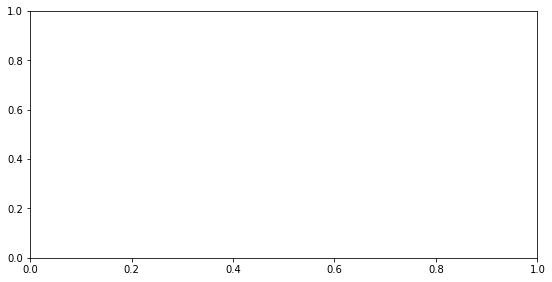

In [30]:
# Plot predictions and uncertainty map for 2 samples 

plt.figure(figsize=(20,10))
plt.subplot(221)
plt.imshow(predictions[0][0,:,:])
plt.title("Prediction sample 1")
plt.subplot(222)
plt.imshow(uncertain_map_array[0])
plt.title("Uncertainty map sample 1")
plt.subplot(223)
plt.imshow(X_test[0][0,:,:])
plt.title("Sample 1")
plt.subplot(224)
plt.imshow(y_test[0][0,:,:])
plt.title("Ground Truth sample 1")
plt.tight_layout()
plt.show()

# Plot predictions and uncertainty map for 2 samples

plt.figure(figsize=(20,10))
plt.subplot(221)
plt.imshow(predictions[1][0,:,:])
plt.title("Prediction sample 2")
plt.subplot(222)
plt.imshow(uncertain_map_array[1])
plt.title("Uncertainty map sample 2")
plt.subplot(223)
plt.imshow(X_test[1][0,:,:])
plt.title("Sample 2")
plt.subplot(224)
plt.imshow(y_test[1][0,:,:])
plt.title("Ground Truth sample 2")
plt.tight_layout()
plt.show()


In [166]:
imsave('prediction.png', predictions[0][0,:,:])
imsave('uncertainty_map.png', uncertain_map_array[0])

imsave('sample.png', X_test[0][0,:,:])
imsave('maks.png', y_test[0][0,:,:])

/home/malub_local/ads_venv/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """Entry point for launching an IPython kernel.
/home/malub_local/ads_venv/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  
/home/malub_local/ads_venv/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  after removing the cwd from sys.path.
/home/malub_local/ads_venv/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  "

In [11]:
def ads(dropout):
    inputs = Input((1, img_rows, img_cols))
    #conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Conv2D(16, (3, 3), padding="same", activation="relu")(inputs)
    conv1 = Conv2D(16, (3, 3), padding="same", activation="relu")(conv1)
    conv1 = Conv2D(16, (3, 3), padding="same", activation="relu")(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)


    conv2 = Conv2D(32, (3, 3), padding="same", activation="relu")(pool1)
    conv2 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv2)
    conv2 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

   
    conv3 = Conv2D(64, (3, 3), padding="same", activation="relu")(pool2)
    conv3 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv3)
    conv3 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), padding="same", activation="relu")(pool3)
    conv4 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv4)
    conv4 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv4)
    
    if dropout:
        conv5 = Dropout(0.5)(conv4)    

    up6_interm = UpSampling2D(size=(2, 2))(conv5)
    
    up6 = concatenate([up6_interm, conv3], axis=1)

    conv6 = Conv2D(64, (3, 3), padding="same", activation="relu")(up6)
    conv6 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv6)
    conv6 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv2], axis=1)

    conv7 = Conv2D(32, (3, 3), padding="same", activation="relu")(up7)
    conv7 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv7)
    conv7 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv1], axis=1)

    conv8 = Conv2D(16, (3, 3), padding="same", activation="relu")(up8)
    conv8 = Conv2D(16, (3, 3), padding="same", activation="relu")(conv8)
    conv8 = Conv2D(16, (3, 3), padding="same", activation="relu")(conv8)

    conv9 = Conv2D(1, (1, 1), activation="softmax")(conv8)

    #model = Model(input=inputs, output=conv10)
    model = Model(outputs=conv9, inputs=inputs)

    #model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])
    #model.compile(optimizer=Adam(lr=1e-3), loss=losses.binary_crossentropy, metrics = [dice_coef])
    model.compile(optimizer=Adam(lr = learning_rate, decay=decay_rate), loss=losses.binary_crossentropy, 
                  metrics = [dice_coef])

    return model



In [12]:
def unet_full_bn(dropout):
    inputs = Input((1, img_rows, img_cols))
    #conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(batch1)


    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(batch2)

   
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(batch3)

    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(pool3)
    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(batch4)
   
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(pool4)
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(conv5)

    if dropout:
        conv5 = Dropout(0.5)(conv5)    

    up6_interm = UpSampling2D(size=(2, 2))(conv5)
    
    up6 = concatenate([up6_interm, conv4], axis=1)

    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(up6)
    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv6)
    batch6 = BatchNormalization(axis=1)(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)

    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(up7)
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv7)
    batch7 = BatchNormalization(axis=1)(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(batch7), conv2], axis=1)

    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv8)
    batch8 = BatchNormalization(axis=1)(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(batch8), conv1], axis=1)

    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation="sigmoid")(batch9)

    #model = Model(input=inputs, output=conv10)
    model = Model(outputs=conv10, inputs=inputs)

    #model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])
    #model.compile(optimizer=Adam(lr=1e-3), loss=losses.binary_crossentropy, metrics = [dice_coef])
    model.compile(optimizer=Adam(lr = learning_rate, decay=decay_rate), loss=losses.binary_crossentropy, 
                  metrics = [dice_coef])

    return model

In [13]:
def unet_bn_descent(dropout):
    inputs = Input((1, img_rows, img_cols))
    #conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(batch1)


    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(batch2)

   
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(batch3)

    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(pool3)
    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(batch4)
   
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(pool4)
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(conv5)

    if dropout:
        conv5 = Dropout(0.5)(conv5)    

    up6_interm = UpSampling2D(size=(2, 2))(conv5)
    
    up6 = concatenate([up6_interm, conv4], axis=1)

    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(up6)
    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)

    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(up7)
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=1)

    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=1)

    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv9)

    conv10 = Conv2D(1, (1, 1), activation="sigmoid")(conv9)

    #model = Model(input=inputs, output=conv10)
    model = Model(outputs=conv10, inputs=inputs)

    #model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])
    #model.compile(optimizer=Adam(lr=1e-3), loss=losses.binary_crossentropy, metrics = [dice_coef])
    model.compile(optimizer=Adam(lr = learning_rate, decay=decay_rate), loss=losses.mean_squared_error, 
                  metrics = [dice_coef])

    return model

In [14]:
def unet_no_bn(dropout):
    inputs = Input((1, img_rows, img_cols))
    #conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)


    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

   
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(pool3)
    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
   
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(pool4)
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(conv5)

    if dropout:
        conv5 = Dropout(0.5)(conv5)    

    up6_interm = UpSampling2D(size=(2, 2))(conv5)
    
    up6 = concatenate([up6_interm, conv4], axis=1)

    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(up6)
    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)

    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(up7)
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=1)

    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=1)

    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv9)

    conv10 = Conv2D(1, (1, 1), activation="sigmoid")(conv9)

    #model = Model(input=inputs, output=conv10)
    model = Model(outputs=conv10, inputs=inputs)

    #model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])
    #model.compile(optimizer=Adam(lr=1e-3), loss=losses.binary_crossentropy, metrics = [dice_coef])
    model.compile(optimizer=Adam(lr = learning_rate, decay=decay_rate), loss=losses.mean_squared_error, 
                  metrics = [dice_coef])

    return model

In [316]:
def data_generator(fill_mode ='reflect', featurewise_center = False, featurewise_std_normalization = False, 
                      rotation_range = 0.0 , horizontal_flip = False, vertical_flip = False, 
                      zca_whitening = False, zca_epsilon = 1e-6, rescale = None, zoom_range = 0.0, 
                      channel_shift_range = 0 , brightness_range=None, shear_range=0.0 ):
    """
    :return: Keras data generator. Data augmentation parameters.
    """
    return ImageDataGenerator(
        fill_mode = fill_mode,
        featurewise_center = featurewise_center,
        featurewise_std_normalization = featurewise_std_normalization,
        rotation_range = rotation_range, 
        horizontal_flip = horizontal_flip,
        vertical_flip = vertical_flip,
        zca_whitening = zca_whitening, 
        zca_epsilon = zca_epsilon, 
        rescale = rescale, 
        zoom_range = zoom_range, 
        channel_shift_range = channel_shift_range, 
        brightness_range=None, shear_range=0.0
    )

In [472]:
X_da = X_train[:2]
y_da = y_train[:2]

In [579]:
sample = X_da[0]

In [627]:
gen1 = data_generator(fill_mode ='reflect', featurewise_center = False, featurewise_std_normalization = False, 
                      rotation_range = 0 , horizontal_flip = False, vertical_flip = False, 
                      zca_whitening = False, zca_epsilon = 1e-6, rescale = None, zoom_range = 0.0, 
                      channel_shift_range = 0 , brightness_range=None, shear_range=0.0)
# rotation range
gen2 = data_generator(fill_mode ='reflect', featurewise_center = False, featurewise_std_normalization = False, 
                      rotation_range = 80.0 , horizontal_flip = False, vertical_flip = False, 
                      zca_whitening = False, zca_epsilon = 1e-6, rescale = None, zoom_range = 0.0, 
                      channel_shift_range = 0 , brightness_range=None, shear_range=0.0)

# feature wise center and std norm
gen3 = data_generator(fill_mode ='reflect', featurewise_center = True, featurewise_std_normalization = True, 
                      rotation_range = 0 , horizontal_flip = False, vertical_flip = False, 
                      zca_whitening = False, zca_epsilon = 1e-6, rescale = None, zoom_range = 0.0, 
                      channel_shift_range = 0 , brightness_range=None, shear_range=0.0)

# zca whitening & flip
gen4 = data_generator(fill_mode ='reflect', featurewise_center = False, featurewise_std_normalization = False, 
                      rotation_range = 0 , horizontal_flip = True, vertical_flip = True, 
                      zca_whitening = True, zca_epsilon = 1e-2, rescale = None, zoom_range = 0.0, 
                      channel_shift_range = 0 , brightness_range=None, shear_range=0.0)

# brightness range
gen5 = data_generator(fill_mode ='reflect', featurewise_center = False, featurewise_std_normalization = False, 
                      rotation_range = 0 , horizontal_flip = False, vertical_flip = False, 
                      zca_whitening = False, zca_epsilon = 1e-6, rescale = None, zoom_range = 0.0, 
                      channel_shift_range = 0 , brightness_range=10, shear_range=0.0)

# Zoom Range and channel shift 
gen6 = data_generator(fill_mode ='reflect', featurewise_center = False, featurewise_std_normalization = False, 
                      rotation_range = 0 , horizontal_flip = False, vertical_flip = False, 
                      zca_whitening = False, zca_epsilon = 1e-6, rescale = None, zoom_range = 0.2, 
                      channel_shift_range = 10 , brightness_range=None, shear_range=0.0)

# shear range
gen7 = data_generator(fill_mode ='reflect', featurewise_center = False, featurewise_std_normalization = False, 
                      rotation_range = 0 , horizontal_flip = False, vertical_flip = False, 
                      zca_whitening = False, zca_epsilon = 1e-6, rescale = None, zoom_range = 0.0, 
                      channel_shift_range = 0 , brightness_range=0, shear_range=45)

# zoom range
gen8 = data_generator(fill_mode ='nearest', featurewise_center = False, featurewise_std_normalization = False, 
                      rotation_range = 80 , horizontal_flip = False, vertical_flip = False, 
                      zca_whitening = False, zca_epsilon = 1e-6, rescale = 10, zoom_range = 0.5, 
                      channel_shift_range = 0 , brightness_range=2, shear_range=0.2)

# shear range
gen9 = data_generator(fill_mode ='reflect', featurewise_center = True, featurewise_std_normalization = True, 
                      rotation_range = 20 , horizontal_flip = True, vertical_flip = True, 
                      zca_whitening = True, zca_epsilon = 1e-6, rescale = None, zoom_range = 0.2, 
                      channel_shift_range = 5, brightness_range=0, shear_range=0)

In [648]:
X_da[0].shape

(1, 512, 512)

In [683]:
generators = [gen1, gen2, gen3, gen4, gen5, gen6, gen7, gen8, gen9]
X = np.zeros((10, 1, 512, 512))
y = np.zeros((10, 1, 512, 512))
i = 0

for gen in generators:
    train_generator = gen.flow(X_da, seed = 2, shuffle=False)
    train_mask_generator = gen.flow(y_da, seed = 2, shuffle=False)
    X[i] = train_generator[0][0]
    y[i] = train_mask_generator[0][0]
    i = i+1
    
X[9] = elastic_transform(X_da[0], X_da.shape[2] * 5, X_da.shape[2] * 0.08, X_da.shape[2] * 0.08)
y[9] = elastic_transform(y_da[0], y_da.shape[2] * 5, y_da.shape[2] * 0.08, y_da.shape[2] * 0.08)

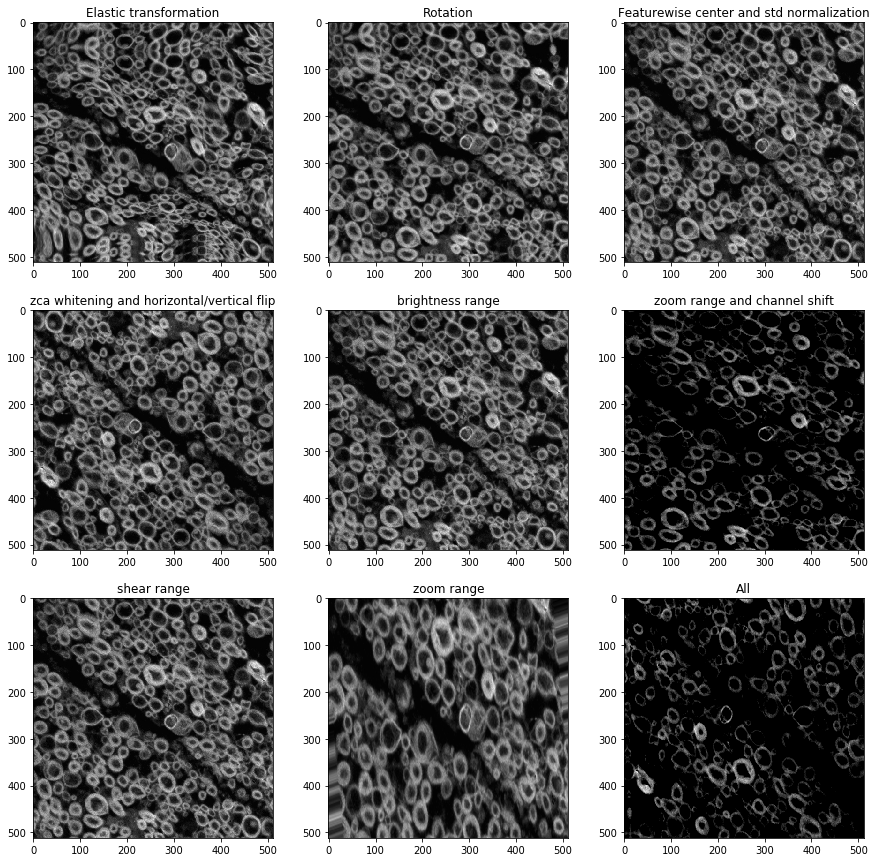

In [684]:
plt.figure(figsize=(15,15))
plt.subplot(331)
plt.imshow(X[9][0, :, :], cmap=plt.get_cmap('gray'))
plt.title("Elastic transformation")
plt.subplot(332)
plt.imshow(X[1].reshape(512, 512), cmap=plt.get_cmap('gray'))
plt.title("Rotation")
plt.subplot(333)
plt.imshow(X[2].reshape(512, 512), cmap=plt.get_cmap('gray'))
plt.title("Featurewise center and std normalization")
plt.subplot(334)
plt.imshow(X[3].reshape(512, 512), cmap=plt.get_cmap('gray'))
plt.title("zca whitening and horizontal/vertical flip")
plt.subplot(335)
plt.imshow(X[4].reshape(512, 512), cmap=plt.get_cmap('gray'))
plt.title("brightness range")
plt.subplot(336)
plt.imshow(X[5].reshape(512, 512), cmap=plt.get_cmap('gray'))
plt.title("zoom range and channel shift")
plt.subplot(337)
plt.imshow(X[6].reshape(512, 512), cmap=plt.get_cmap('gray'))
plt.title("shear range")
plt.subplot(338)
plt.imshow(X[7].reshape(512, 512), cmap=plt.get_cmap('gray'))
plt.title("zoom range")
plt.subplot(339)
plt.imshow(X[8].reshape(512, 512), cmap=plt.get_cmap('gray'))
plt.title("All")
plt.show()

In [617]:
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[1:]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

In [649]:
sample

array([[[-1.7005856 , -1.4090513 , -1.299726  , ...,  0.39481676,
          0.3037123 ,  0.44947943],
        [-1.79169   , -1.463714  , -1.2632842 , ...,  0.21260786,
         -0.26113528, -0.29757705],
        [-1.8827945 , -1.7370274 , -1.5001558 , ..., -0.26113528,
         -0.8806455 , -0.9170873 ],
        ...,
        [-0.26113528, -1.0446335 , -1.7188065 , ..., -1.7370274 ,
         -1.7552483 , -1.463714  ],
        [ 0.1579452 , -0.42512327, -1.2815051 , ..., -1.5548185 ,
         -1.5548185 , -1.5183767 ],
        [ 0.10328253, -0.09714726, -0.7348784 , ..., -1.3908305 ,
         -1.3361678 , -1.5001558 ]]], dtype=float32)

In [671]:
elastic = elastic_transform(X_da[0], sample.shape[2] * 15, sample.shape[2] * 0.08, sample.shape[2] * 0.08)
elastic.shape

(1, 512, 512)

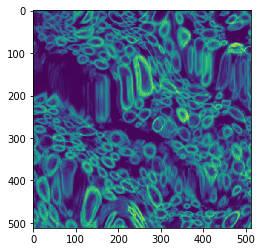

In [672]:
plt.imshow(elastic[0, :, :])

In [670]:
X_da.shape[2]

512

0 1 2
1 3 4
2 5 6


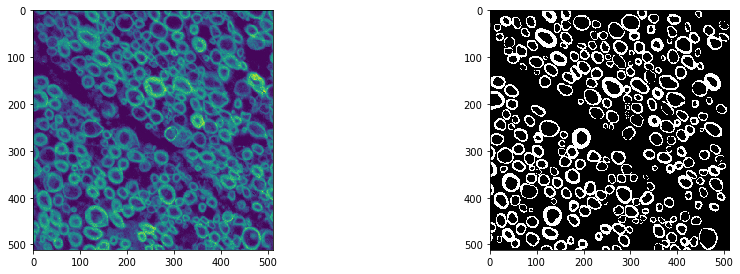

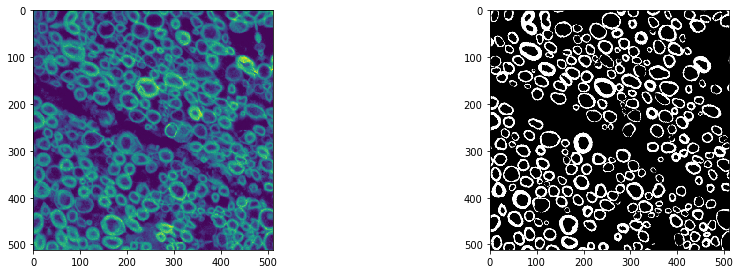

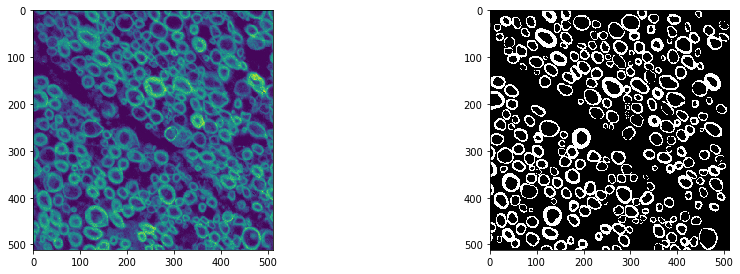

In [525]:
# configure batch size and retrieve one batch of images
for i in range(0,3):
    plt.figure(figsize=(15,15))
    plt.subplot(320 + (2*i +1))
    plt.imshow(X[i].reshape(512, 512))
    print(i,  2*i + 1,  2*i+2 )
    plt.subplot(320 + (2*i+2) )
    plt.imshow(y[i].reshape(512, 512), cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [423]:
# data augmentation

datagen = data_generator()

datagen.fit(X_train)

train_generator = gen1.flow(X_da, seed = 2, shuffle=False)
train_mask_generator = gen1.flow(y_da, seed = 2, shuffle=False)



val_generator = datagen.flow(X_valid, seed = 2, 
                                      batch_size=12, 
                                      shuffle=False)

val_mask_generator = datagen.flow(y_valid, seed = 2, 
                                      batch_size=12, 
                                      shuffle=False)

(2, 1, 512, 512)


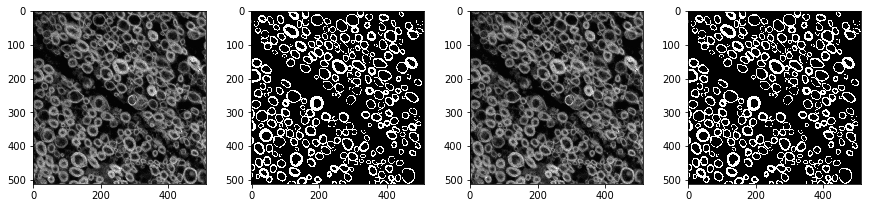

In [341]:
# configure batch size and retrieve one batch of images
for X_batch, y_batch in zip(train_generator, train_mask_generator):
    plt.figure(figsize=(15,7))
    print(X_batch.shape)
    for i in range(0, 2):
        plt.subplot(240 + 2*i +1)
        plt.imshow(X_batch[0].reshape(512, 512), cmap=plt.get_cmap('gray'))
        plt.subplot(240 + 2*i + 2)
        plt.imshow(y_batch[0].reshape(512, 512), cmap=plt.get_cmap('gray'))
# show the plot
    plt.show()
    break
    
    

(2, 1, 512, 512)


IndexError: index 2 is out of bounds for axis 0 with size 2

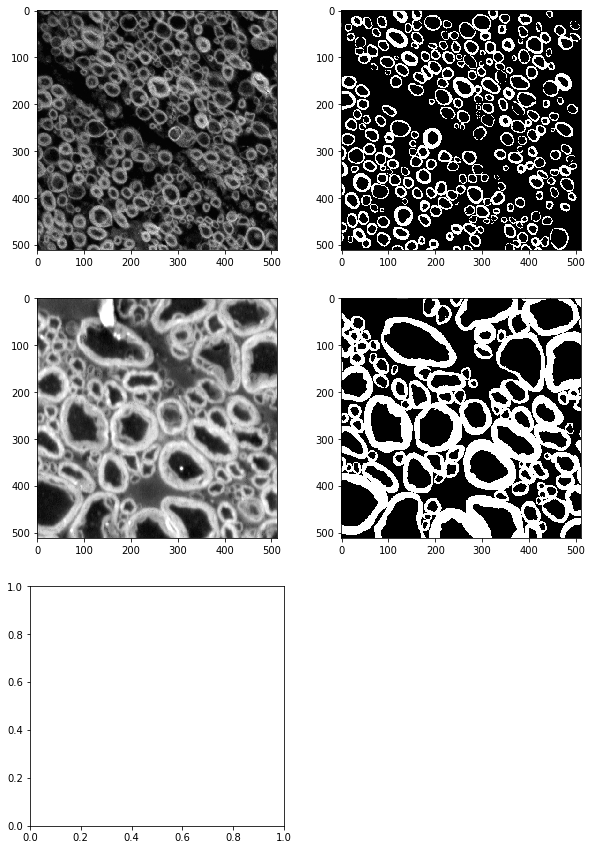

In [436]:
# configure batch size and retrieve one batch of images
for X_batch, y_batch in zip(train_generator, train_mask_generator):
    plt.figure(figsize=(10,15))
    print(X_batch.shape)
    for i in range(0, 3):
        plt.subplot(320 + 2*i +1)
        plt.imshow(X_batch[i].reshape(512, 512), cmap=plt.get_cmap('gray'))
        plt.subplot(320 + 2*i + 2)
        plt.imshow(y_batch[i].reshape(512, 512), cmap=plt.get_cmap('gray'))
# show the plot
    plt.show()
    break

In [ ]:
def plotImages( images_arr, n_images=4):
    fig, axes = plt.subplots(n_images, n_images, figsize=(12,12))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        if img.ndim != 2:
            img = img.reshape( (SIZE,SIZE))
        ax.imshow( img, cmap="Greys_r")
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()

In [593]:
print("Computing log predictions ...\n")
predictions = predict(X_test, model)

Computing log predictions ...



In [596]:
X_test.shape

(1, 1, 512, 512)

In [603]:
compute_dice_coef(predictions[0], y_test[0])

0.05683753799141494

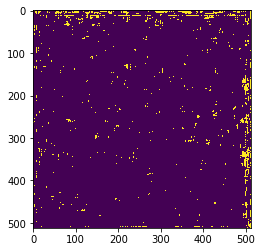

In [602]:
plt.imshow(predictions[0][0,:,:])

In [611]:
path_img_valid

'src/data/data_rosenberg2/images_valid_29.npy'

In [605]:
# CEAL data definition
X_valid, y_valid = load_data(path_img_valid, path_mask_valid)
print("*************Xvalid.shape***********", X_valid.shape)


Loading data...

*************Xvalid.shape*********** (29, 1, 512, 512)


In [608]:
X_test = X_valid[-2:]
y_test = y_valid[-2:]

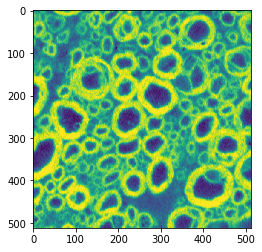

In [613]:
plt.imshow(X_test[0][0,:,:])